## Rescale Score 
---

In this notebook let's explore the option to rescale score such that current user RG distribution would significantly.

First, let's plot the correlation between the old score and the new score to get a sense of the preservation of the rank order. I don't the Lorenz curve by design measures rank order, but we can cook up something like that by ploting rank orders.

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [3]:
mmonth = "202103"
s3_base_path = f"s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/{mmonth}"
# train_df = pd.read_parquet(os.path.join(s3_base_path, "dev_train_20201201_scored.parquet"))
test_df = pd.read_parquet(os.path.join(s3_base_path, "dev_test_20201201_scored.parquet"))

pred_cols = ['score_20191231', 
             'score_20201130_wo_ind', 
             'score_20201130_w_ind']

# produce active indicator
# had transactions in the past 30 days
test_df["is_active"] = (test_df.nr_past_transactions > 0) & (test_df.nr_transactions_30d > 0)
df_ = test_df[test_df.is_active]

In [4]:
sample_rate = 0.1
if 0 <= sample_rate < 1:
    df_ = df_.sample(frac=sample_rate)
else:
    df_ = test_df

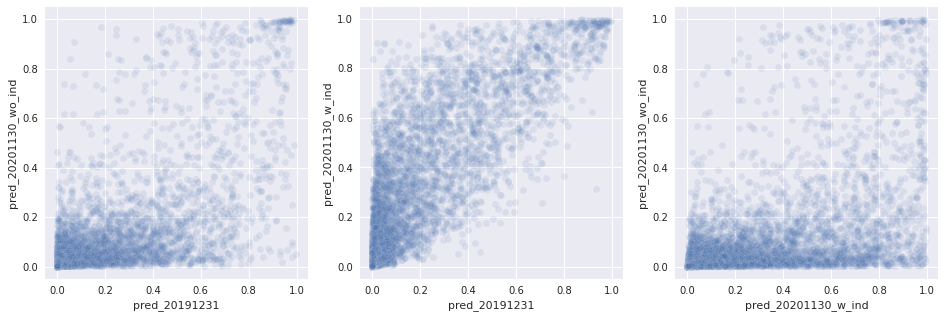

In [5]:
fig, axs = plt.subplots(1,3, figsize=(16, 5))
sns.scatterplot(x=df_.pred_20191231, 
                y=df_.pred_20201130_wo_ind, 
                alpha=0.1,
                ax=axs[0])
sns.scatterplot(x=df_.pred_20191231, 
                y=df_.pred_20201130_w_ind, 
                alpha=0.1,
                ax=axs[1])
sns.scatterplot(x=df_.pred_20201130_w_ind, 
                y=df_.pred_20201130_wo_ind, 
                alpha=0.1,
                ax=axs[2])
plt.show()

In [6]:
pred_cols = ["pred_20191231", "pred_20201130_wo_ind", "pred_20201130_w_ind"]
test_df[pred_cols].corr()

,pred_20191231,pred_20201130_wo_ind,pred_20201130_w_ind
pred_20191231,1.000000,0.847741,0.443681
pred_20201130_wo_ind,0.847741,1.000000,0.179210
pred_20201130_w_ind,0.443681,0.179210,1.000000


Looking at plots, excluding indeterminant from training data still have significantly higher correlation with the original model. Let's look at scores. Does the non-linearity comes from scaling change it?

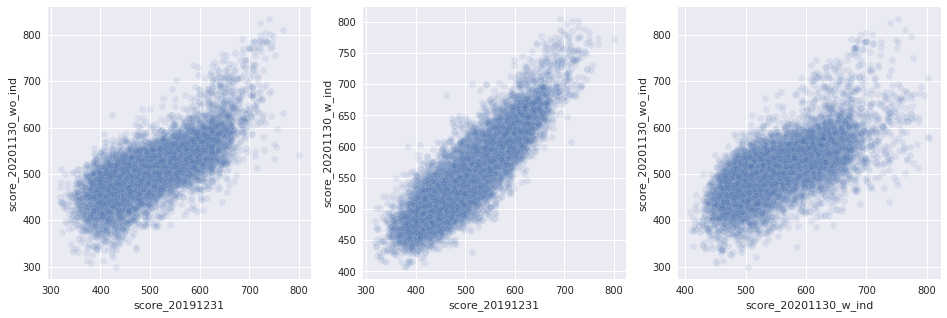

In [7]:
fig, axs = plt.subplots(1,3, figsize=(16, 5))
sns.scatterplot(x=df_.score_20191231, 
                y=df_.score_20201130_wo_ind, 
                alpha=0.1,
                ax=axs[0])
sns.scatterplot(x=df_.score_20191231, 
                y=df_.score_20201130_w_ind, 
                alpha=0.1,
                ax=axs[1])
sns.scatterplot(x=df_.score_20201130_w_ind, 
                y=df_.score_20201130_wo_ind, 
                alpha=0.1,
                ax=axs[2])
plt.show()

In [8]:
pred_cols = ["score_20191231", "score_20201130_wo_ind", "score_20201130_w_ind"]
test_df[pred_cols].corr()

,score_20191231,score_20201130_wo_ind,score_20201130_w_ind
score_20191231,1.000000,0.861099,0.696113
score_20201130_wo_ind,0.861099,1.000000,0.474929
score_20201130_w_ind,0.696113,0.474929,1.000000


Translating to score definitely made it better, but still there is a huge gap.

### "Lorenz Curve"

In [9]:
df_ = test_df.copy()

In [10]:
df_.sort_values(by=["score_20191231"], inplace=True)
df_["rank_score_20191231"] = range(len(df_))

df_.sort_values(by=["score_20201130_wo_ind"], inplace=True)
df_["rank_score_20201130_wo_ind"] = range(len(df_))

df_.sort_values(by=["score_20201130_w_ind"], inplace=True)
df_["rank_score_20201130_w_ind"] = range(len(df_))

let's plot spaced by 10 points?

In [11]:
idx = range(1, len(df_), 10)

<AxesSubplot:xlabel='rank_score_20191231', ylabel='rank_score_20201130_w_ind'>

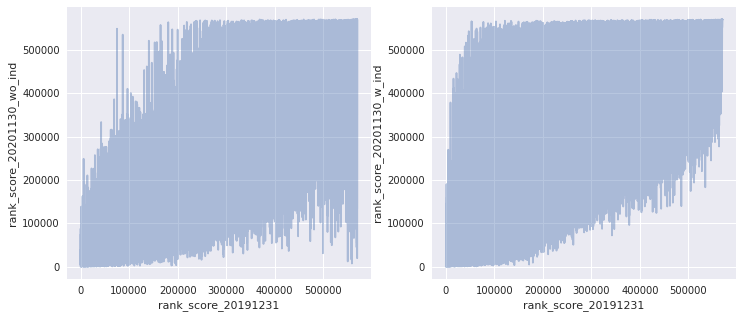

In [12]:
fig, axs = plt.subplots(1,2, figsize=(12, 5))

sns.lineplot(data=df_.iloc[idx, :], x="rank_score_20191231", y="rank_score_20201130_wo_ind", alpha=0.4, ax=axs[0])
sns.lineplot(data=df_.iloc[idx, :], x="rank_score_20191231", y="rank_score_20201130_w_ind", alpha=0.4, ax=axs[1])

Neither shows good behavior here. Last Attempt, let's just look at RG segmentations

### RG shifts
---

In [13]:
test_df.columns[test_df.columns.str.contains("rg")]

Index(['target', 'target_with_restriction', 'rg_20191231',
       'rg_20201130_wo_ind', 'rg_20201130_w_ind',
       'rg_rescaled_20201130_w_ind'],
      dtype='object')

#### Trained excluding indeterminant - same scaling

Text(0.5, 1.0, 'Risk Group Shift - excluded indeterminant')

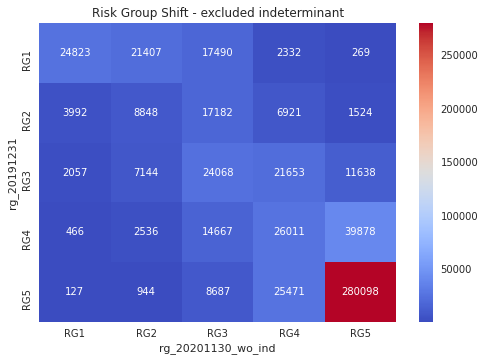

In [14]:
# compare the flow of risk groups 
table = test_df[['rg_20191231', 'rg_20201130_wo_ind']].value_counts().sort_index().reset_index()
table.columns = ['rg_20191231', 'rg_20201130_wo_ind', 'counts']
table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                       columns='rg_20201130_wo_ind', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - excluded indeterminant')

'pct persisted'

0.6380689998649676

Text(0.5, 1.0, 'Risk Group Shift - excluded indeterminant')

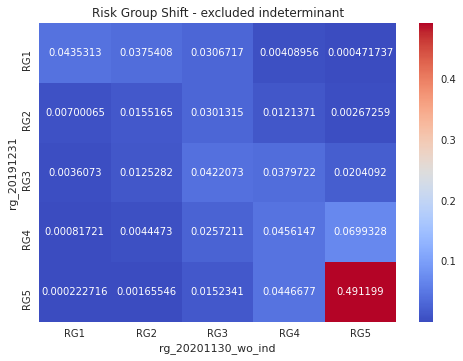

In [15]:
# compare the flow of risk groups 
table = test_df[['rg_20191231', 'rg_20201130_wo_ind']].value_counts(normalize=True).sort_index().reset_index()
table.columns = ['rg_20191231', 'rg_20201130_wo_ind', 'counts']
table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                       columns='rg_20201130_wo_ind', fill_value=0)
display("pct persisted", np.trace(table.values))
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - excluded indeterminant')

#### Trained including indeterminant data - same scaling

Text(0.5, 1.0, 'Risk Group Shift - w ind included for training')

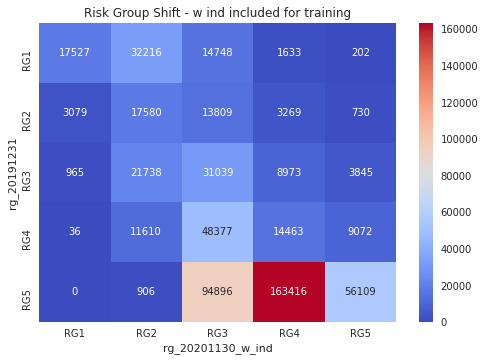

In [16]:
table = test_df[['rg_20191231', 'rg_20201130_w_ind']].value_counts().sort_index().reset_index()
table.columns = ['rg_20191231', 'rg_20201130_w_ind', 'counts']
table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                       columns='rg_20201130_w_ind', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - w ind included for training')

'pct persisted'

0.23975603169203036

Text(0.5, 1.0, 'Risk Group Shift - w ind included for training')

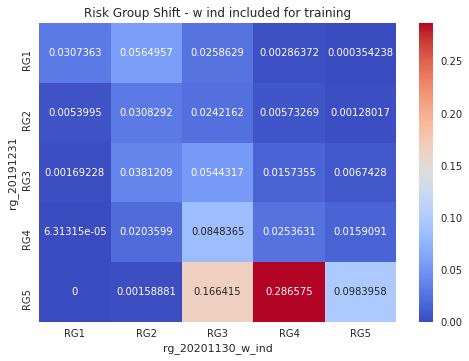

In [17]:
table = test_df[['rg_20191231', 'rg_20201130_w_ind']].value_counts(normalize=True).sort_index().reset_index()
table.columns = ['rg_20191231', 'rg_20201130_w_ind', 'counts']
table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                       columns='rg_20201130_w_ind', fill_value=0)
display("pct persisted", np.trace(table.values))
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - w ind included for training')

#### Trained including indeterminant data - rescaling

Text(0.5, 1.0, 'Risk Group Shift - w ind included for training')

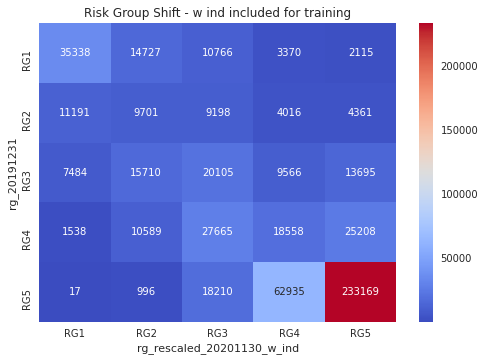

In [18]:
table = test_df[['rg_20191231', 'rg_rescaled_20201130_w_ind']].value_counts().sort_index().reset_index()
table.columns = ['rg_20191231', 'rg_rescaled_20201130_w_ind', 'counts']
table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                       columns='rg_rescaled_20201130_w_ind', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - w ind included for training')

'pct persisted'

0.5556917583843656

Text(0.5, 1.0, 'Risk Group Shift - w ind included for training')

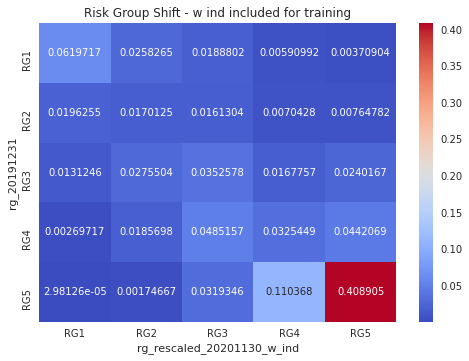

In [19]:
table = test_df[['rg_20191231', 'rg_rescaled_20201130_w_ind']].value_counts(normalize=True).sort_index().reset_index()
table.columns = ['rg_20191231', 'rg_rescaled_20201130_w_ind', 'counts']
table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                       columns='rg_rescaled_20201130_w_ind', fill_value=0)
display("pct persisted", np.trace(table.values))
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - w ind included for training')

### Define an optimization process to minimize score shift

In [20]:
def get_risk_groups(serie, cutoffs):
    return pd.cut(serie.round(), cutoffs, 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

def scale_scores_(predictions,
                 alpha = 631.9455383610933, 
                 beta = 30.812519272450654):
    """
    Convert probability to score.
    """
    try:
        assert ((predictions >= 0) & (predictions <= 1)).all(), 'probability must be in range [0,1]'
    except AssertionError:
        raise
    # Minimum and maximum values for validation
    MINIMUM = 300
    MAXIMUM = 850

    score = np.minimum(np.maximum(np.log(predictions / (1 - predictions)) * beta + alpha, MINIMUM), MAXIMUM)
   
    return score

In [21]:
def fn(arg):
    """ distance between the original score distribution and the newly rescaled score distribution """
    cutoffs, alpha, beta = sorted(arg[:6]), arg[6], arg[7]
    test_df["score_rescaled_"] = scale_scores_(
        test_df.pred_20201130_w_ind, alpha, beta)
    
    test_df["rg_rescaled_"] = get_risk_groups(test_df["score_rescaled_"],
                                              cutoffs)
    
    table = test_df[['rg_20191231', 
                     'rg_rescaled_']].value_counts(
        normalize=True).sort_index().reset_index()
    table.columns = ['rg_20191231', 'rg_rescaled_', 'counts']
    table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                           columns='rg_rescaled_', fill_value=0)
    return 1-np.trace(table.values)
    
    

In [22]:
from scipy.optimize import minimize

cutoffs = sorted([300, 474, 510, 560, 600, 850])
x = cutoffs + [743.17590331,  59.30207539]
minimize(fn, x0=x, method="COBYLA", tol=1e-7)

     fun: 0.36707129303904684
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 157
  status: 1
 success: True
       x: array([300.44667538, 477.3695362 , 511.60993014, 558.74714869,
       594.43336099, 850.83497763, 751.37779252,  52.02789045])

Okay...this I guess the rescale and cut off optimization cannot be so clean after all. Maybe need to zoom in deeper but looking at the correlation plot, do not think it is ever possible.

In [23]:
arg = [300, 477.4 , 511.6, 558.7,
       594.4, 850.8, 751.4,  52.0]
cutoffs, alpha, beta = sorted(arg[:6]), arg[6], arg[7]
test_df["score_rescaled_"] = scale_scores_(
    test_df.pred_20201130_w_ind, alpha, beta)
    
test_df["rg_rescaled_"] = get_risk_groups(test_df["score_rescaled_"], cutoffs)

'pct persisted'

0.6328673290801385

Text(0.5, 1.0, 'Risk Group Shift - jointly optimized with rg segmentations')

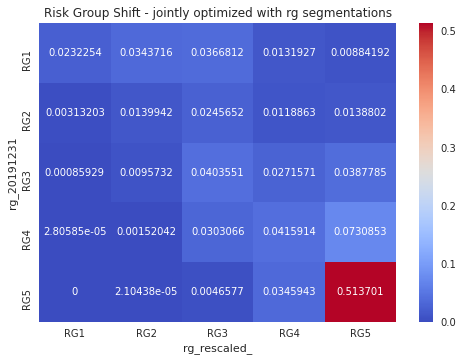

In [24]:
table = test_df[['rg_20191231', 'rg_rescaled_']].value_counts(normalize=True).sort_index().reset_index()
table.columns = ['rg_20191231', 'rg_rescaled_', 'counts']
table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                       columns='rg_rescaled_', fill_value=0)
display("pct persisted", np.trace(table.values))
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - jointly optimized with rg segmentations')

### Rescale based on bad sccounts
---

Get segmented performance and then interpolate!

In [25]:
score_cols = ["score_20191231",
 "score_20201130_wo_ind",
 "score_20201130_w_ind"]
pred_cols = ["pred_20191231",
 "pred_20201130_wo_ind",
 "pred_20201130_w_ind"]
test_df[score_cols+pred_cols].head()

,score_20191231,score_20201130_wo_ind,score_20201130_w_ind,pred_20191231,pred_20201130_wo_ind,pred_20201130_w_ind
12703,420.468318,469.918623,501.152627,0.001044,0.005176,0.014136
17074,672.159133,601.775548,734.573168,0.786693,0.273061,0.965468
19216,686.239774,593.844827,733.324311,0.853470,0.225040,0.964090
31532,702.193300,689.979414,742.556065,0.907194,0.868007,0.973137
37589,432.498815,485.394187,557.724063,0.001542,0.008525,0.082503


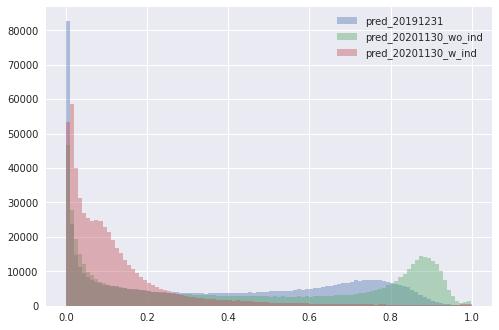

In [26]:
plt.style.use("seaborn")
for col in pred_cols:
    test_df[col].hist(bins=100, alpha=0.4, label=col)
plt.legend()

In [27]:
%%time
import src.monitoring.monitoring as mntr

pctl = np.linspace(0, 99, 100)[::-1]
pred_old = mntr.build_table1(test_df, pctl, "target", "pred_20191231")
pred_new = mntr.build_table1(test_df, pctl, "target", "pred_20201130_w_ind")

CPU times: user 3min 20s, sys: 16.4 ms, total: 3min 20s
Wall time: 3min 20s


In [28]:
pred_old.shape

(100, 9)

In [29]:
pred_old.head()

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,99.0,0.897600,0.786417,20.133376,5703,1268,5030,4435,559515
1,98.0,0.874578,1.750155,24.372817,11405,1535,4763,9870,554080
2,97.0,0.859413,2.733930,26.833916,17108,1690,4608,15418,548532
3,96.0,0.847441,3.720365,29.040965,22810,1829,4469,20981,542969
4,95.0,0.836918,4.710347,30.946332,28513,1949,4349,26564,537386


In [30]:
pred_new.head()

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,99.0,0.831220,0.550049,41.298825,5703,2601,3697,3102,560848
1,98.0,0.687592,1.454739,50.825659,11405,3201,3097,8204,555746
2,97.0,0.591118,2.403227,56.446491,17108,3555,2743,13553,550397
3,96.0,0.521293,3.354021,61.845030,22810,3895,2403,18915,545035
4,95.0,0.465591,4.316517,66.211496,28513,4170,2128,24343,539607


#### Cannot simply do the table approach, need sort and produce again

In [31]:
df = test_df[["business_account_number", "target"] + pred_cols]

In [32]:
df.head()

,business_account_number,target,pred_20191231,pred_20201130_wo_ind,pred_20201130_w_ind
12703,410002346024,False,0.001044,0.005176,0.014136
17074,410010139461,True,0.786693,0.273061,0.965468
19216,410010124014,True,0.853470,0.225040,0.964090
31532,410010157744,True,0.907194,0.868007,0.973137
37589,410002553835,False,0.001542,0.008525,0.082503


In [33]:
def get_bad_rate(df, pred_col):
    df_ = df.copy()
    
    df_.sort_values(by=[pred_col], ascending=False, inplace=True)
    df_["tot_rank_<TMP>"] = range(len(df_))
    df_["tot_rank_<TMP>"] = df_["tot_rank_<TMP>"] + 1
    df_["bad_rank_<TMP>"] = df_.target.cumsum()
    df_["bad_rate"] = df_["bad_rank_<TMP>"] / (df_["tot_rank_<TMP>"])
    
    assert(not df_.bad_rate.isna().any())
    
    result =  df_["bad_rate"]
    return result

### Produce different bad rate threshold

In [34]:
df = test_df[["business_account_number", "target"] + pred_cols + score_cols]

# bad rate for 20191231
br = get_bad_rate(df, "pred_20191231").rename("bad_rate_20191231")
df = pd.merge(df, br, left_index=True, right_index=True)

# bad rate for 20201130
br = get_bad_rate(df, "pred_20201130_w_ind").rename("bad_rate_20201130_w_ind")
df = pd.merge(df, br, left_index=True, right_index=True)

In [35]:
df.head()

,business_account_number,target,pred_20191231,pred_20201130_wo_ind,pred_20201130_w_ind,score_20191231,score_20201130_wo_ind,score_20201130_w_ind,bad_rate_20191231,bad_rate_20201130_w_ind
12703,410002346024,False,0.001044,0.005176,0.014136,420.468318,469.918623,501.152627,0.011456,0.012783
17074,410010139461,True,0.786693,0.273061,0.965468,672.159133,601.775548,734.573168,0.040839,0.835240
19216,410010124014,True,0.853470,0.225040,0.964090,686.239774,593.844827,733.324311,0.088815,0.831379
31532,410010157744,True,0.907194,0.868007,0.973137,702.193300,689.979414,742.556065,0.277909,0.854181
37589,410002553835,False,0.001542,0.008525,0.082503,432.498815,485.394187,557.724063,0.011623,0.021750


In [36]:
plt.style.use('seaborn')

<AxesSubplot:xlabel='score_20201130_w_ind', ylabel='bad_rate_20201130_w_ind'>

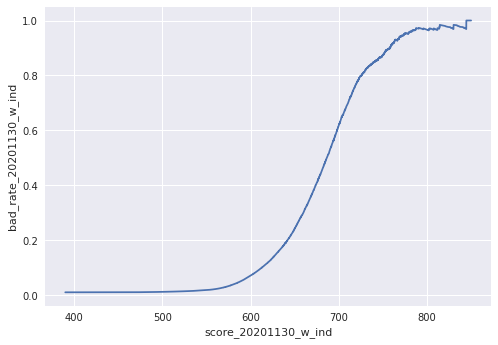

In [37]:
score_col = "score_20201130_w_ind"
br_col = "bad_rate_20201130_w_ind"
df_ = df[[score_col, br_col]].sort_values(score_col)
sns.lineplot(x=df_[score_col], y=df_[br_col])

<AxesSubplot:xlabel='score_20191231', ylabel='bad_rate_20191231'>

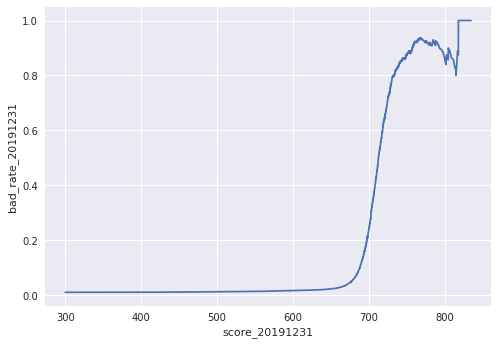

In [38]:
score_col = "score_20191231"
br_col = "bad_rate_20191231"
df_ = df[[score_col, br_col]].sort_values(score_col)
sns.lineplot(x=df_[score_col], y=df_[br_col])

#### Align bad rates
---
* score_20191231
* score_20201130_w_ind
* bad_rate_20191231
* bad_rate_20201130_w_ind

Essentilly we split df into multiple bins w.r.t. both scores, then we align the bad_rates.

First let's produce alignment..because bad rates are not monotonic, let's produce high watermarks and align based on first occurances. ignoring the dips.

<AxesSubplot:xlabel='score_20201130_w_ind', ylabel='bad_rate_20201130_w_ind'>

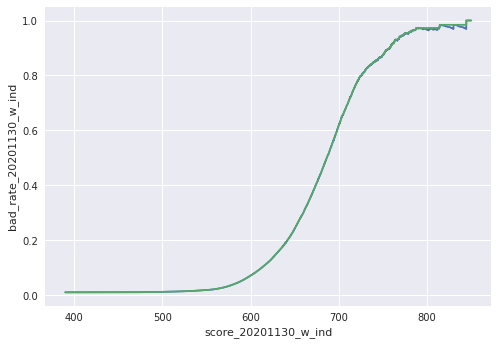

In [39]:
score_col = "score_20201130_w_ind"
br_col = "bad_rate_20201130_w_ind"
cummax_col = "br_cummax_20201130_w_ind"

df.sort_values(score_col, inplace=True, ascending=True)
df[cummax_col] = df[br_col].cummax()
sns.lineplot(x=df[score_col], y=df[br_col])
sns.lineplot(x=df[score_col], y=df[cummax_col])

<AxesSubplot:xlabel='score_20191231', ylabel='bad_rate_20191231'>

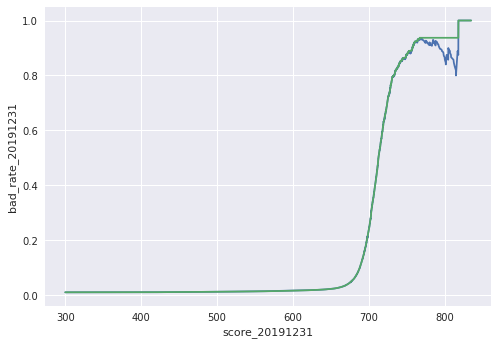

In [40]:
score_col = "score_20191231"
br_col = "bad_rate_20191231"
cummax_col = "br_cummax_20191231"

df.sort_values(score_col, inplace=True, ascending=True)
df[cummax_col] = df[br_col].cummax()
sns.lineplot(x=df[score_col], y=df[br_col])
sns.lineplot(x=df[score_col], y=df[cummax_col])

Let's align bad rates of the new score w.r.t. the old bad rate at the old rg cutoffs.

Can we create a score-to-score table matched by bad_rates? Can we do it using merge_asof?

In [41]:
score_col = "score_20191231"
br_col = "br_cummax_20191231"

# sort score in ascending order and keep the first bad rate cutoff
br_tbl_20191231 = df[[score_col, br_col]]
br_tbl_20191231[br_col] = br_tbl_20191231[br_col].round(3)
br_tbl_20191231 = br_tbl_20191231.sort_values(by=score_col).drop_duplicates(br_col, keep="first")

In [42]:
score_col = "score_20201130_w_ind"
br_col = "br_cummax_20201130_w_ind"
br_tbl_20201130 = df[[score_col, br_col]]
br_tbl_20201130[br_col] = br_tbl_20201130[br_col].round(3)
br_tbl_20201130 = br_tbl_20201130.sort_values(by=score_col).drop_duplicates(br_col, keep="first")

In [43]:
br_tbl_20191231.shape, br_tbl_20201130.shape

((862, 2), (958, 2))

In [44]:
br_tbl_20191231.head(), br_tbl_20201130.head()

(         score_20191231  br_cummax_20191231
 5045502      300.000000               0.011
 5069497      423.860651               0.012
 5292328      478.416816               0.013
 5260647      517.661267               0.014
 5166565      552.224177               0.015,
          score_20201130_w_ind  br_cummax_20201130_w_ind
 5055480            389.776321                     0.011
 5120675            475.295499                     0.012
 5060769            496.829450                     0.013
 5324277            510.523038                     0.014
 5585725            521.265321                     0.015)

#### Cumulative Bad Rate

In [45]:
br_tbl_20191231["score_20191231"] = br_tbl_20191231["score_20191231"].round()
br_tbl_20191231 = br_tbl_20191231.drop_duplicates(subset="score_20191231", keep="first")

br_tbl_20201130["score_20201130_w_ind"] = br_tbl_20201130["score_20201130_w_ind"].round()
br_tbl_20201130 = br_tbl_20201130.drop_duplicates(subset="score_20201130_w_ind", keep="first")


In [46]:
br_score_table = pd.merge(br_tbl_20191231, 
                          br_tbl_20201130,
                          left_on="br_cummax_20191231",
                          right_on="br_cummax_20201130_w_ind",
                          how="inner")
br_score_table["bad_rate"] = br_score_table["br_cummax_20191231"]
br_score_table = br_score_table[["bad_rate", "score_20191231", "score_20201130_w_ind"]]
br_score_table.sort_values("bad_rate", inplace=True)

for col in br_score_table.columns:
    assert(br_score_table[col].is_monotonic_increasing)
display(br_score_table.head())

br_score_table["score_20191231"] = br_score_table["score_20191231"].round()
br_score_table["score_20201130_w_ind"] = br_score_table["score_20201130_w_ind"].round()

br_score_table = br_score_table.drop_duplicates(subset=["score_20191231", "score_20201130_w_ind"], keep="first")
br_score_table = br_score_table.loc[br_score_table["score_20191231"] != br_score_table["score_20201130_w_ind"], :]

# add boundaries after dropping duplicates
br_score_table.iloc[0, :] = [0.0, 300, 300]  # append first row
br_score_table.iloc[-1, :] = [1.0, 850, 850]  # append last row

br_score_table = br_score_table.reset_index(drop=True)
br_score_table.shape

,bad_rate,score_20191231,score_20201130_w_ind
0,0.011,300.0,390.0
1,0.012,424.0,475.0
2,0.013,478.0,497.0
3,0.014,518.0,511.0
4,0.015,552.0,521.0


(54, 3)

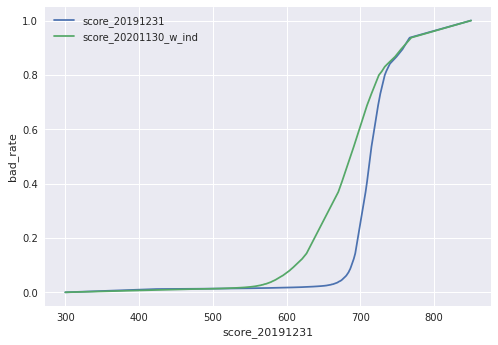

In [47]:
sns.lineplot(x=br_score_table["score_20191231"],
             y=br_score_table["bad_rate"], label="score_20191231")
sns.lineplot(x=br_score_table["score_20201130_w_ind"], 
             y=br_score_table["bad_rate"], label="score_20201130_w_ind")
plt.legend()

In [48]:
# produce bins
# produce mapper
# produce interpolation function

In [49]:
df_ = br_score_table
src_col = "score_20191231"
tgt_col = "score_20201130_w_ind"

src_t = df_[src_col].round()  # source threshold
src_bins = list(zip(src_t[:-1], src_t[1:]))

tgt_t = df_[tgt_col].round()
tgt_bins = list(zip(tgt_t[:-1], tgt_t[1:]))

In [50]:
# we take the first n-1 rows, use the lower bound as the "base"
df_ = br_score_table.iloc[:-1]
df_["src_bin"] = src_bins
df_["tgt_bin"] = tgt_bins

cutoffs = src_t
mapper_dict = {}  # src_label : (src_bin, tgt_bin, bad_rate)
for idx, row in df_.iterrows():
    mapper_dict[str(row["src_bin"])] = (row["src_bin"], row["tgt_bin"], row["bad_rate"])

In [51]:
def get_aligned_score(df, score_alignment_table,
                      src_col, tgt_col):
    """
    df and score_alignment_table must contains a 
        src_col and tgt_col as columns
        
    # NOTE: score_alignment_table must be sorted in ascending order!
    """
    assert(score_alignment_table[src_col].is_monotonic_increasing)
    assert(score_alignment_table[tgt_col].is_monotonic_increasing)
    
    print(src_col, tgt_col)
    tbl = score_alignment_table.copy()
    
    src_t = tbl[src_col].round()  # source threshold
    src_bins = list(zip(src_t[:-1], src_t[1:]))

    tgt_t = tbl[tgt_col].round()
    tgt_bins = list(zip(tgt_t[:-1], tgt_t[1:]))
    
    tbl = tbl.iloc[:-1]
    tbl["src_bin"] = src_bins
    tbl["tgt_bin"] = tgt_bins

    cutoffs = src_t
    mapper_dict = {}  # src_label : (src_bin, tgt_bin, bad_rate)
    for idx, row in tbl.iterrows():
        mapper_dict[row["src_bin"]] = (row["src_bin"], row["tgt_bin"], row["bad_rate"])

    score_df = df[src_col].copy().to_frame()
    score_df["bin"] = pd.cut(df[src_col], cutoffs,
                 right=True, include_lowest=True,
                 labels=tbl["src_bin"].tolist()) 
    
    def map_interpolate(score, src_bin_str):
        (sl, su), (tl, tu), bad_rate = mapper_dict[src_bin_str]
        return (score-sl) / (su-sl) * (tu - tl) + tl
        
    result = score_df.apply(lambda row: map_interpolate(row[src_col], row["bin"]), axis=1)
        
    return result


In [52]:
test_df.head(100)["score_20201130_w_ind"], get_aligned_score(test_df.head(100), br_score_table, 
                  "score_20201130_w_ind", "score_20191231")

score_20201130_w_ind score_20191231


(12703     501.152627
 17074     734.573168
 19216     733.324311
 31532     742.556065
 37589     557.724063
              ...    
 763855    743.844748
 782324    697.405788
 792926    731.750397
 821594    492.572303
 827112    722.451980
 Name: score_20201130_w_ind, Length: 100, dtype: float64,
 12703     489.864648
 17074     738.786584
 19216     738.162156
 31532     745.000459
 37589     643.810157
              ...    
 763855    746.160273
 782324    718.202894
 792926    737.062798
 821594    467.132017
 827112    731.471188
 Length: 100, dtype: float64)

In [53]:
%%time
test_df["score_rescaled_20201130_w_ind_bad_rate"] = get_aligned_score(
    test_df, br_score_table, 
    "score_20201130_w_ind", "score_20191231")

score_20201130_w_ind score_20191231
CPU times: user 7.51 s, sys: 51.3 ms, total: 7.56 s
Wall time: 7.56 s


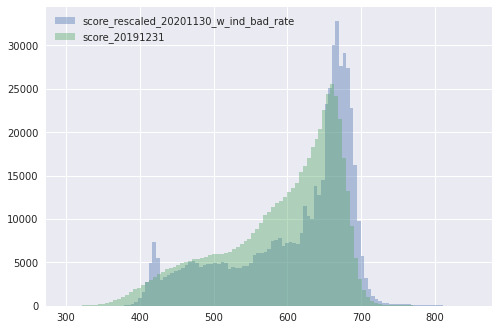

In [54]:
test_df.score_rescaled_20201130_w_ind_bad_rate.hist(bins=100, alpha=0.4, label="score_rescaled_20201130_w_ind_bad_rate")
test_df.score_20191231.hist(bins=100, alpha=0.4, label="score_20191231")
plt.legend()

In [55]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])


test_df["rg_rescaled_20201130_w_ind_bad_rate"] = get_risk_groups(test_df["score_rescaled_20201130_w_ind_bad_rate"])

'pct persisted'

367281

Text(0.5, 1.0, 'Risk Group Shift - by bad rate')

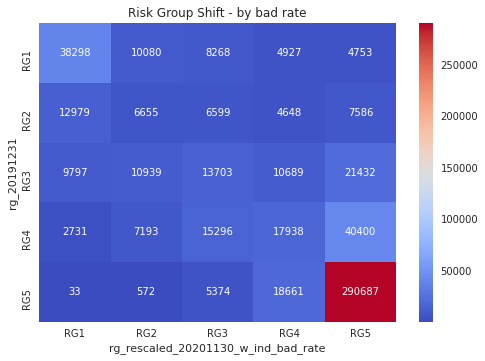

In [56]:
table = test_df[['rg_20191231', 'rg_rescaled_20201130_w_ind_bad_rate']].value_counts(normalize=False).sort_index().reset_index()
table.columns = ['rg_20191231', 'rg_rescaled_20201130_w_ind_bad_rate', 'counts']
table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                       columns='rg_rescaled_20201130_w_ind_bad_rate', fill_value=0)
display("pct persisted", np.trace(table.values))
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - by bad rate')

'pct persisted'

0.6440836983855864

Text(0.5, 1.0, 'Risk Group Shift - by bad rate')

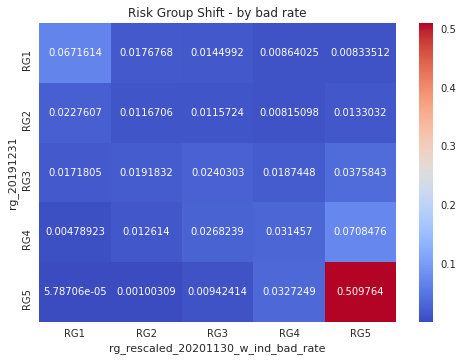

In [57]:
table = test_df[['rg_20191231', 'rg_rescaled_20201130_w_ind_bad_rate']].value_counts(normalize=True).sort_index().reset_index()
table.columns = ['rg_20191231', 'rg_rescaled_20201130_w_ind_bad_rate', 'counts']
table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                       columns='rg_rescaled_20201130_w_ind_bad_rate', fill_value=0)
display("pct persisted", np.trace(table.values))
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift - by bad rate')

In [58]:
cols = ['business_account_number', 'user_id', 'borrower_id', 'sample_date', 
        'pred_20191231', 'pred_20201130_w_ind', 'pred_20201130_wo_ind',
        'score_20191231', 'score_20201130_w_ind', 'score_20201130_wo_ind',
        'score_rescaled_20201130_w_ind','score_rescaled_20201130_w_ind_bad_rate',  ### THE GOAL
        'rg_20191231', 'rg_rescaled_20201130_w_ind_bad_rate']
test_df[cols].head()
test_df[cols].to_parquet("s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-03/validation_df_20211201_only_scores.parquet")
test_df[cols].to_csv("s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-03/validation_df_20211201_only_scores.csv")

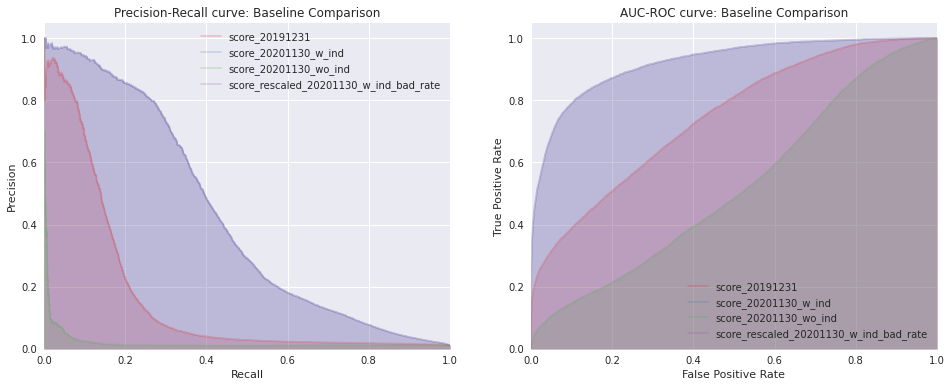

In [62]:
mntr_path = "./artifacts"
score_cols = ['score_20191231', 'score_20201130_w_ind', 
              'score_20201130_wo_ind', 'score_rescaled_20201130_w_ind_bad_rate']
mntr.save_valid_performance_plots(
        {"20201201-inactive": test_df}, "target", score_cols, mntr_path, dropna=False
    )
# looks good, they match!

(471246, 110)

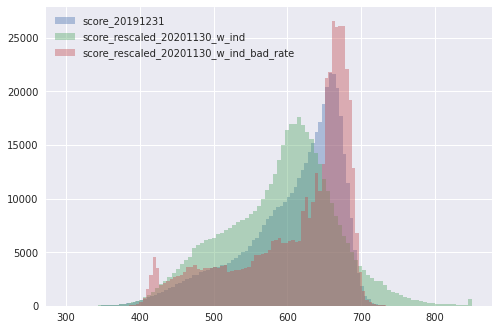

In [60]:
df_ = test_df[~test_df.is_active 
              & ~test_df.target]
display(df_.shape)

score_col = "score_20191231"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_rescaled_20201130_w_ind"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_rescaled_20201130_w_ind_bad_rate"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

plt.legend()

(570248, 110)

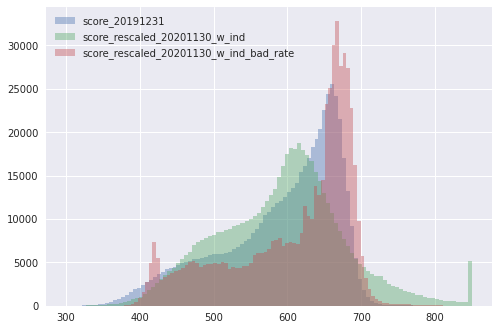

In [61]:
df_ = test_df
display(df_.shape)

score_col = "score_20191231"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_rescaled_20201130_w_ind"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_rescaled_20201130_w_ind_bad_rate"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

plt.legend()

In [68]:
score_col = "score_20191231"
rg_col = "rg_20191231"
cols = [score_col, rg_col, "target"]
tgt_br = test_df[cols].groupby(rg_col)["target"].mean().sort_index()
display("target bad rate: ", tgt_br)


def get_risk_groups(serie, cutoffs):
    return pd.cut(serie.round(), cutoffs, 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

def fn(arg):
    """ distance between the original score distribution and the newly rescaled score distribution """
    cutoffs = sorted(arg[:6])
    
    test_df["rg_rescaled_"] = get_risk_groups(test_df["score_rescaled_20201130_w_ind_bad_rate"],
                                              cutoffs)
    
    table = test_df[['rg_20191231', 
                     'rg_rescaled_']].value_counts(
        normalize=True).sort_index().reset_index()
    table.columns = ['rg_20191231', 'rg_rescaled_', 'counts']
    table = pd.pivot_table(table, values='counts', index='rg_20191231', 
                           columns='rg_rescaled_', fill_value=0)
    return 1-np.trace(table.values)
    

'target bad rate: '

rg_20191231
RG1    0.000618
RG2    0.001638
RG3    0.004342
RG4    0.006427
RG5    0.017024
Name: target, dtype: float64

#### Interval Bad Rate
---

Maybe should again take the optimizer approach

In [ ]:
score_col = "score_20191231"
rg_col = "rg_20191231"
cols = [score_col, rg_col, "target"]
tgt_br = test_df[cols].groupby(rg_col)["target"].mean().sort_index()
display("target bad rate: ", tgt_br)


def fn(arg):
    """ distance between the original score distribution and the newly rescaled score distribution """
    cutoffs = sorted(arg)
    
    test_df["rg_rescaled_"] = get_risk_groups(test_df["score_rescaled_20201130_w_ind"],
                                              cutoffs)
    
    rescaled_br = test_df[["rg_rescaled_", "target"]].groupby(
        "rg_rescaled_")["target"].mean().sort_index()
    
    cost_fn = np.sqrt(((rescaled_br.values - tgt_br.values) ** 2).sum())
    return cost_fn
    

In [ ]:
from scipy.optimize import minimize

cutoffs = sorted([300, 474, 510, 560, 600, 850])
minimize(fn, x0=cutoffs, method="COBYLA", tol=1e-7)

In [ ]:
cutoffs = sorted([300, 474, 510, 560, 600, 850])
minimize(fn, x0=cutoffs, method="Powell", tol=1e-7)

In [ ]:
cutoffs = [296.7640277 , 340.20808663, 363.03357055, 404.20308048,
           530.39673101, 860.47197629]
cutoffs_cleaned = [300, 340, 363, 404, 530, 850]

fn(cutoffs_cleaned)
rescaled_br = test_df[["rg_rescaled_", "target"]].groupby(
        "rg_rescaled_")["target"].agg(["mean", "count"]).sort_index()

In [ ]:
rescaled_br

#### Bad Rate not monotonic, count distribution is too biased

Let's also add a loss to shifit in counts

In [ ]:
score_col = "score_20191231"
rg_col = "rg_20191231"
cols = [score_col, rg_col, "target"]
tgt_br = test_df[cols].groupby(rg_col)["target"].mean().sort_index()
tgt_pcts = test_df[rg_col].value_counts(normalize=True).sort_index()
display("target bad rate: ", tgt_br, tgt_pcts)


def fn(arg):
    """ distance between the original score distribution and the newly rescaled score distribution """
    cutoffs = sorted([300] + arg.tolist() + [850])
    print(cutoffs)
    a,b = 10,1
    test_df["rg_rescaled_"] = get_risk_groups(test_df["score_rescaled_20201130_w_ind"],
                                              cutoffs)
    
    rescaled_br = test_df[["rg_rescaled_", "target"]].groupby(
        "rg_rescaled_")["target"].mean().sort_index()
    rescaled_pcts = test_df["rg_rescaled_"].value_counts(normalize=True).sort_values()
    
    cost_fn_br = np.sqrt(((rescaled_br.values - tgt_br.values) ** 2).sum())
    cost_fn_pcts = np.sqrt(((rescaled_pcts.values - tgt_pcts.values) ** 2).sum())
    cost_fn = a * cost_fn_br + b * cost_fn_pcts
    print("=====================================")
    print(cost_fn_br, cost_fn_pcts, cost_fn)

    return cost_fn
    

In [ ]:
# cutoffs = sorted([474, 510, 560, 600])
# result = minimize(fn, x0=cutoffs, method="Powell", tol=1e-7)

In [ ]:
cutoffs = result["x"]
fn(cutoffs)

In [ ]:
test_df[["rg_rescaled_", "target"]].groupby(
        "rg_rescaled_")["target"].mean().sort_index()

In [ ]:
test_df["rg_rescaled_"].value_counts(normalize=True).sort_values()